In [80]:
import ete3
import os
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations, product
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS
from scipy.stats import wilcoxon, ttest_ind
import re
import multiprocessing
import subprocess
#import plotly
#import plotly.plotly as ptl
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

%cd /work/site_rate/hemimastigophora

/work/site_rate/hemimastigophora


In [15]:
trees = []
names = []
random.seed(12345)
for category in range(1,13):
    ufboot = open('categories/%i.boot.ufboot' % category).read().split('\n')
    ufboot.pop()
    trees.extend(random.sample(ufboot, 100))
    names.extend(['rate_%i' % category]*100)

trees.append(open('CAT_61tax_h0.42_g1.bmge.fas.UFboot.tre').read().strip())
names.append('CAT_61tax_h0.42_g1.bmge')
#trees.append(open('CAT_58tax-nDP_h0.42_g1.bmge.fas.UFboot.tre').read().strip())
#names.append('CAT_58tax-nDP_h0.42_g1.bmge')
#trees.append(open('CAT_58tax-nLB_h0.42_g1.bmge.fas.UFboot.tre').read().strip())
#names.append('CAT_58tax-nLB_h0.42_g1.bmge')

In [16]:
for filename in os.listdir('selected_categories/'):
    if not filename.endswith('.ufboot'):
        continue
    ufboot = open('selected_categories/%s' % filename).read().split('\n')
    ufboot.pop()
    trees.extend(random.sample(ufboot, 100))
    names.extend([filename.replace('.aln.ufboot', '')]*100)

In [11]:
for treefile in os.listdir('7_tree files/61-SFSR'):
    if treefile.endswith('.tre') and '.bmge' in treefile:
        tree_txt = open('7_tree files/61-SFSR/%s' % treefile).read().strip()
        trees.append(re.sub(r'\[\\\[&label=\S+?\\\]\]', '', tree_txt))
        names.append(treefile.replace('.fas.tre', ''))

In [19]:
out = open('rf_trees.treelist', 'w')
out.write('\n'.join(trees))
out.close()

#subprocess.call(['iqtree', '-t', 'rf_trees.treelist', '-rf_all'])
subprocess.call(['raxmlHPC-PTHREADS-SSE3', '-m', 'GTRCAT', '-N', '15',
                 '-z', 'rf_trees.treelist', '-f', 'r', '-n', 'rf_distances'])

0

In [20]:
distances = []
for line in open('RAxML_RF-Distances.rf_distances').readlines():
    distances.append(float(line.split()[-1]))

df = pd.DataFrame(index=names, columns=names, data=squareform(distances))

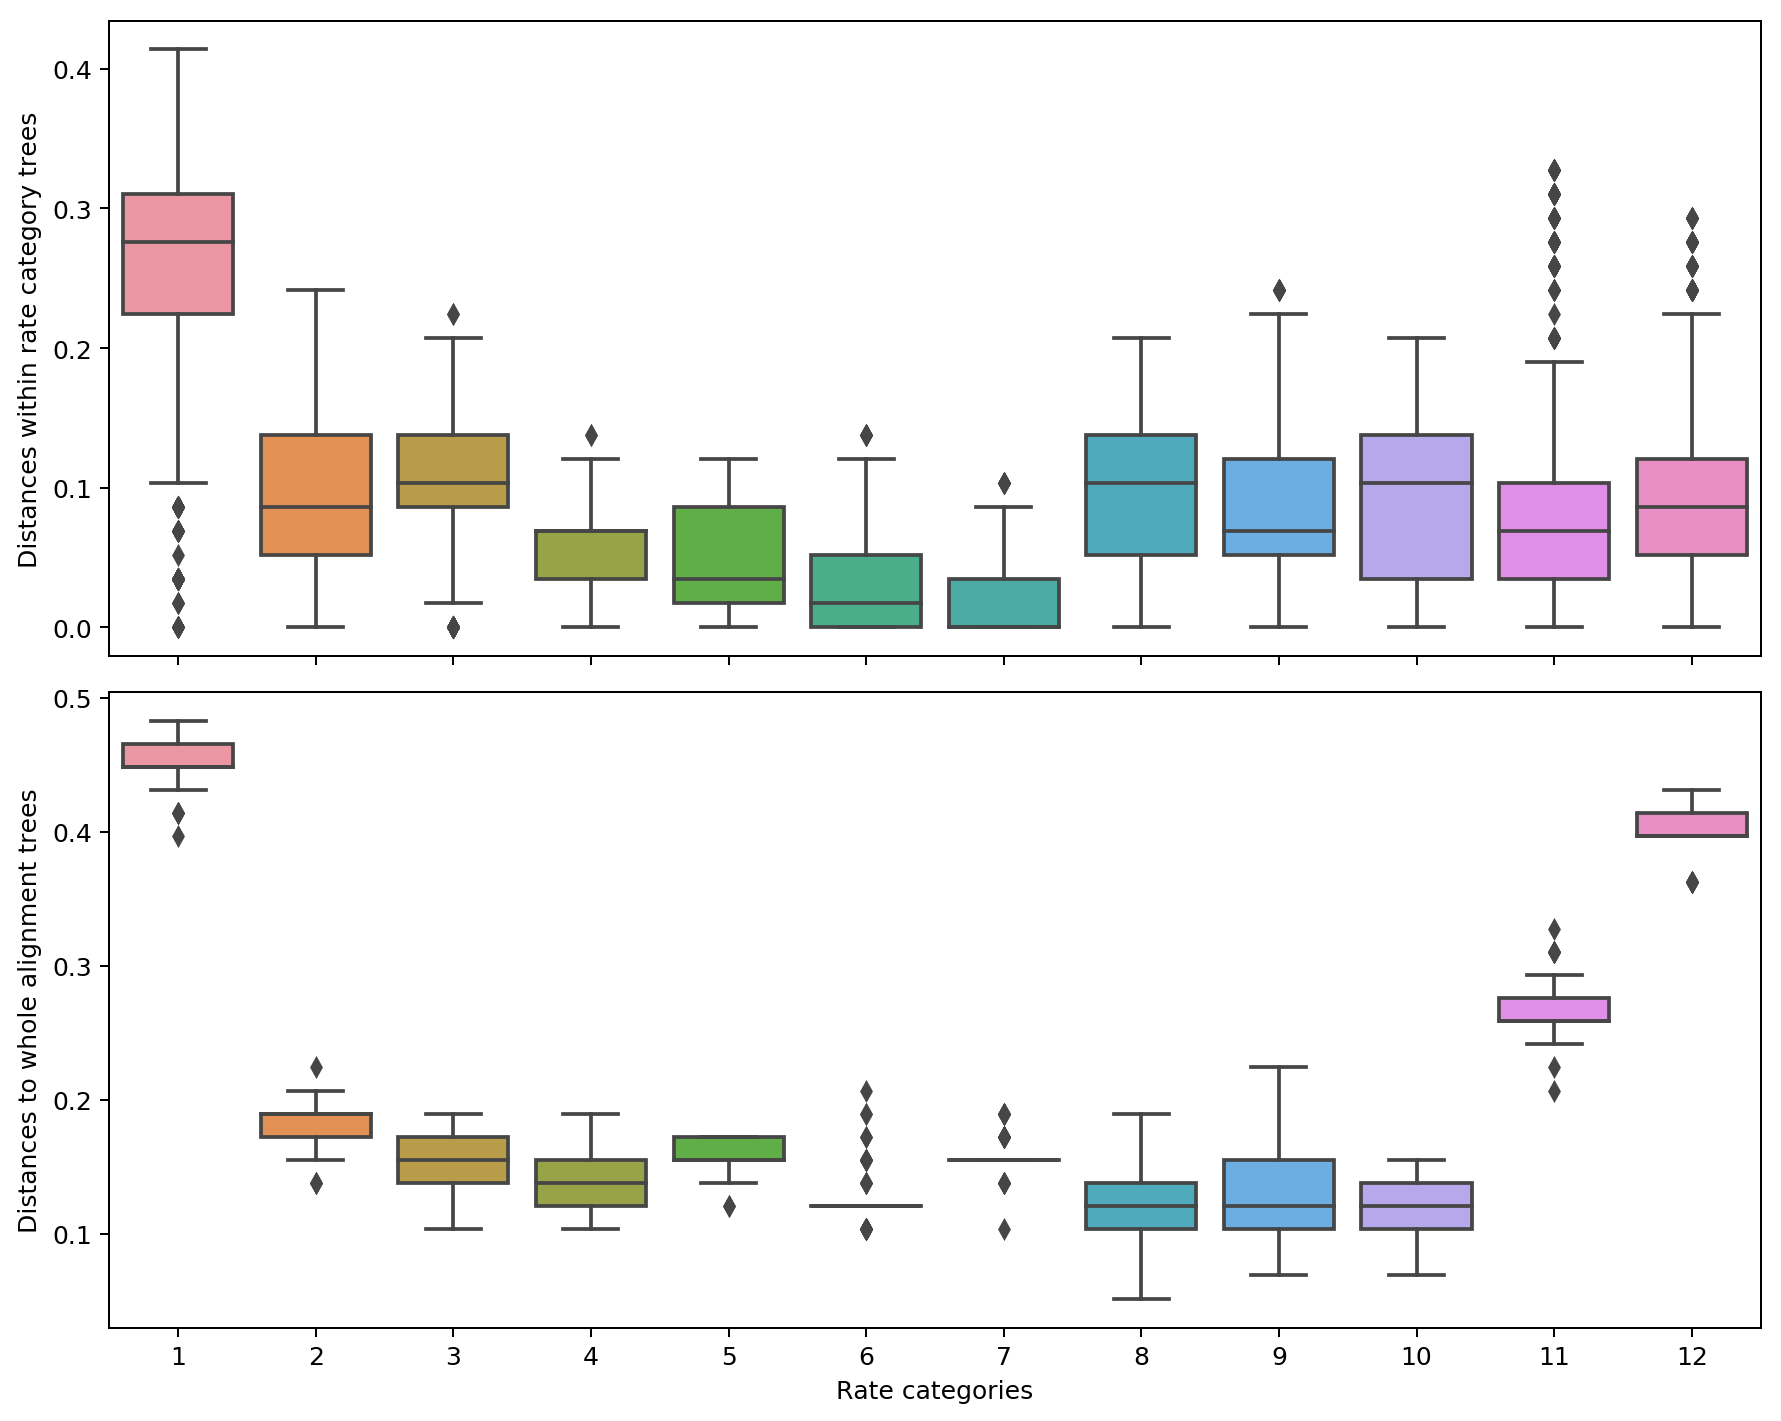

In [4]:
intra_distances = []
for category in range(1,13):
    category_indexes = df.index[df.index == 'rate_%i' % category]
    tmp_df = df.loc[df.index=='rate_%i' % category, df.columns=='rate_%i' % category].copy()
    intra_distances.append(squareform(tmp_df.values))

fig, axs = plt.subplots(nrows=2, sharex=True, dpi=180, figsize=(10,8))
sns.boxplot(x=range(1,13), y=intra_distances, ax=axs[0])
axs[0].set_ylabel('Distances within rate category trees')

whole_alignment_indexes = df.index[df.index.str.startswith('whole')]
distances_to_whole_aln = []
for category in range(1,13):
    category_indexes = df.index[df.index == 'rate_%i' % category]
    tmp_df = df.loc[df.index=='rate_%i' % category, df.columns=='CAT_61tax_h0.42_g1.bmge'].copy()
    distances_to_whole_aln.append(tmp_df.values.flatten())
    
sns.boxplot(x=range(1,13), y=distances_to_whole_aln, ax=axs[1])
axs[1].set_ylabel('Distances to whole alignment trees')
axs[1].set_xlabel('Rate categories')

fig.tight_layout()

In [67]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=6)
coords    = embedding.fit_transform(df.values)
coords_df = pd.DataFrame(data=coords, columns='x y'.split(), index=df.index)
        
coords_df['gene_type'] = coords_df.index.tolist()
coords_df.loc[coords_df['gene_type'] == 'CAT_61tax_h0.42_g1.bmge', 'gene_type'] = 'whole alignment'

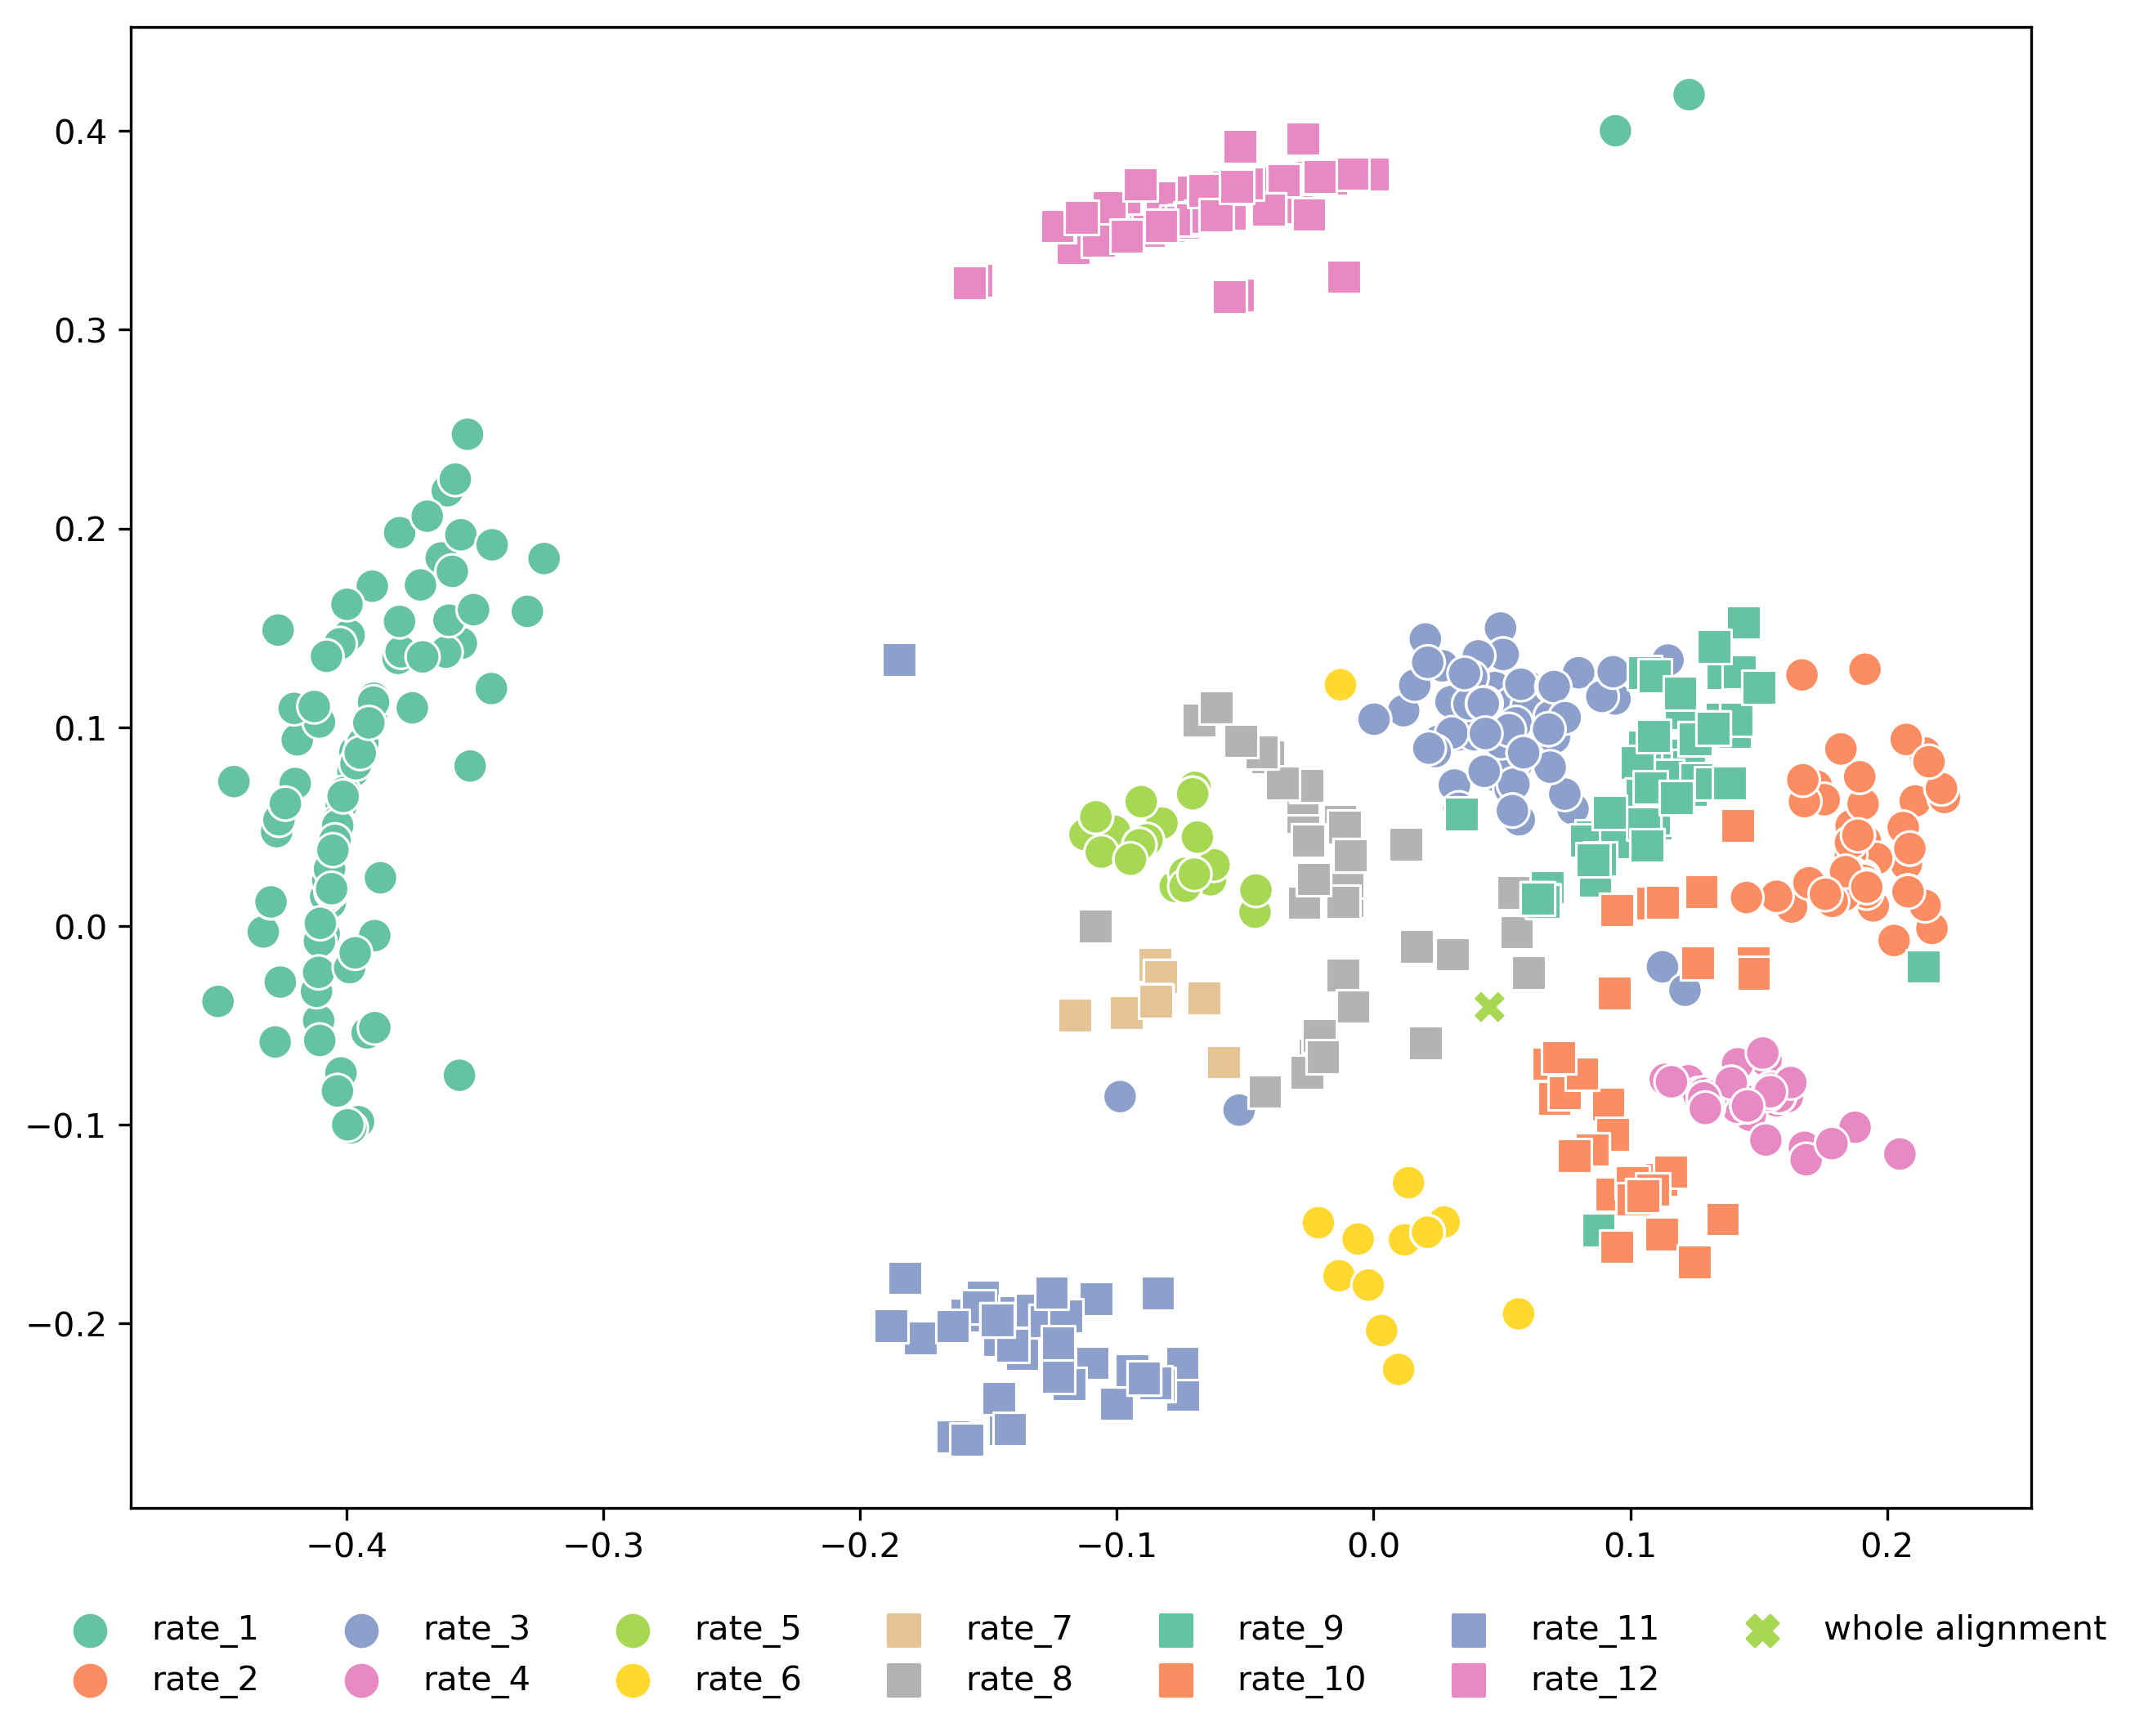

In [77]:
markers = {'rate_%i' % num:'o' for num in range(1,7)}
markers.update({'rate_%i' % num:'s' for num in range(7,13)})
markers['whole alignment'] = 'X'
#markers['CAT_58tax-nDP_h0.42_g1.bmge'] = 'X'
#markers['CAT_58tax-nLB_h0.42_g1.bmge'] = 'X'
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
sns.scatterplot(x='x', y='y', hue='gene_type',
                style='gene_type', data=coords_df.drop(['missing-11_12', 'missing-1_2', 'missing-1_2_11_12']),
                ax=ax, s=100, palette="Set2",
                markers=markers, alpha=1)
ax.set_xlabel('')
ax.set_ylabel('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], markerscale=1.5,
          loc=10, bbox_to_anchor=(0.5, -0.1), ncol=7, frameon=False)

In [24]:
cmap        = plt.get_cmap('rainbow')
color_range = ['#%02x%02x%02x' % cmap(value, bytes=True)[:3] for value in np.linspace(0, 1, 6)]
data        = []
marker_shapes = ['circle', 'square', 'triangle-up', 'diamond', 'star']
for gene_type, (shape,color) in zip(coords_df.gene_type.unique(), product(marker_shapes, color_range)):
    tmp    = coords_df[coords_df.gene_type == gene_type]
    
    data.append(
        go.Scatter(x=tmp.x.values, y=tmp.y.values, mode='markers', text=tmp.index,
               name=gene_type, hoverinfo='text', showlegend=True,
               marker=dict(size=[20 if index.endswith('.bmge') or index.startswith('missing') else 10
                                   for index in tmp.index],color=color, opacity=.7,
                           symbol=['star' if index.endswith('.bmge') or index.startswith('missing') else shape
                                   for index in tmp.index])
        )
    )
layout    = go.Layout(title='Geodesic distances', hovermode='closest', width=1200, height=1000)
fig       = go.Figure(data=data, layout=layout)
iplot(fig)

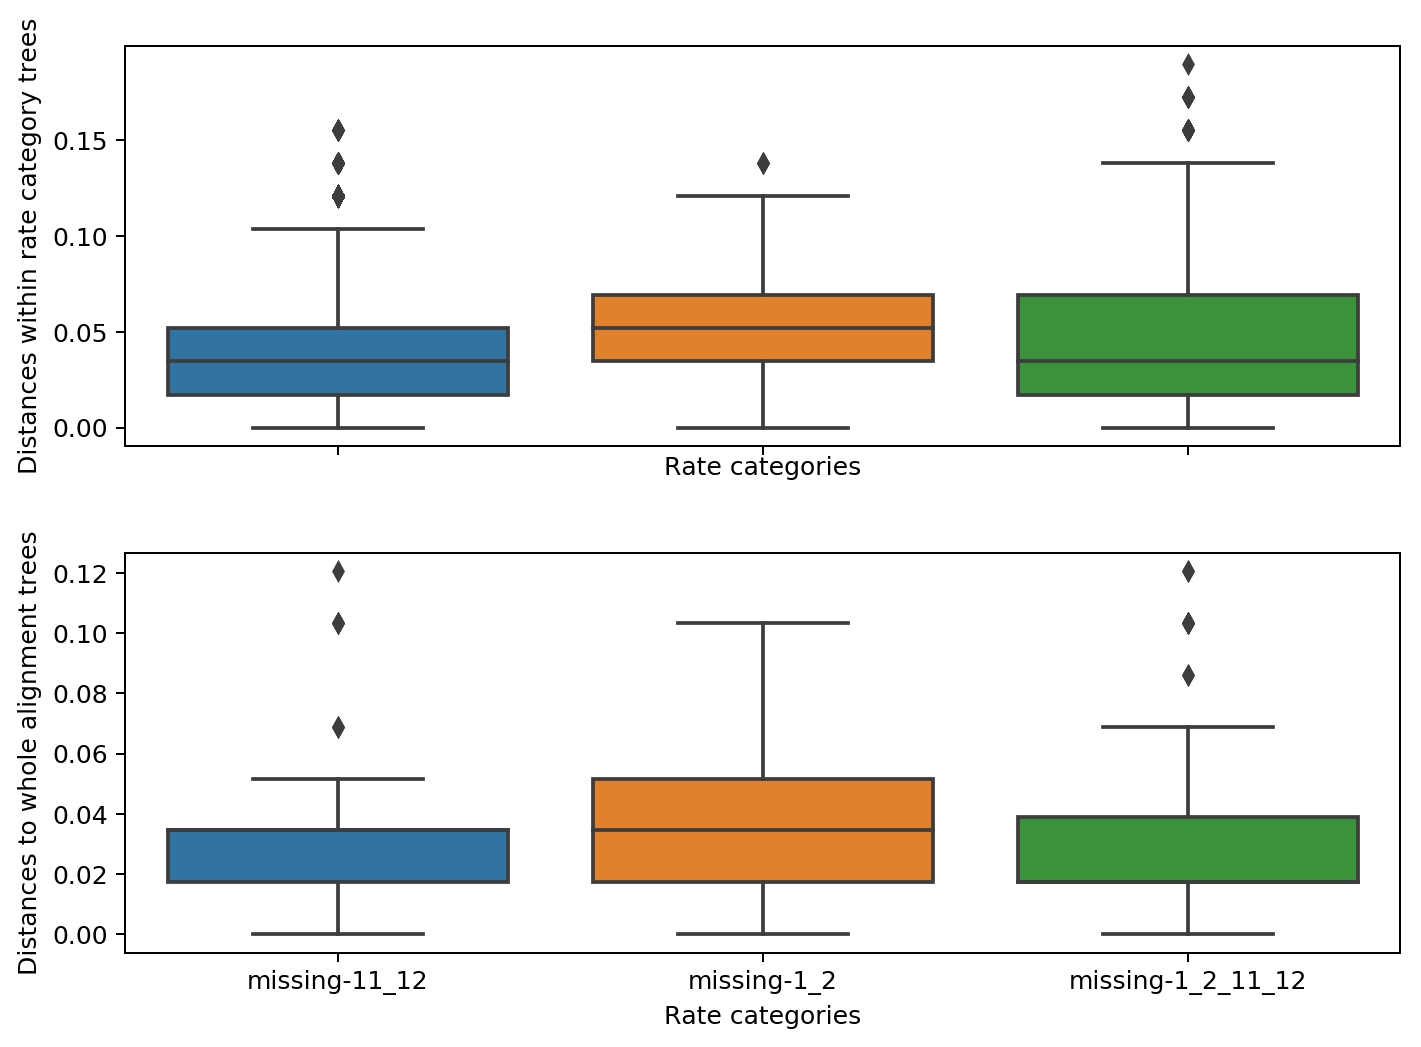

In [68]:
intra_distances = pd.DataFrame(columns=['tree group', 'distance'])
for category in ['missing-11_12', 'missing-1_2', 'missing-1_2_11_12']:
    tmp_df = df.loc[df.index==category, df.columns==category].copy()
    intra_distances = intra_distances.append(
        pd.DataFrame(
            data=zip([category]*4950, squareform(tmp_df.values)), 
            columns=['tree group', 'distance']),
        ignore_index=True)

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8,6), dpi=180)
sns.boxplot(x='tree group', y='distance', data=intra_distances, ax=axs[0])
axs[0].set_ylabel('Distances within rate category trees')

whole_alignment_indexes = df.index[df.index.str.startswith('CAT_61tax_h0.42_g1.bmge')]
distances_to_whole_aln = pd.DataFrame(columns=['tree group', 'distance'])
for category in ['missing-11_12', 'missing-1_2', 'missing-1_2_11_12']:
    category_indexes = df.index[df.index == category]
    tmp_df = df.loc[df.index==category, df.columns=='CAT_61tax_h0.42_g1.bmge'].copy()
    distances_to_whole_aln = distances_to_whole_aln.append(pd.DataFrame(
            data=zip([category]*len(category_indexes), tmp_df.values.flatten()), 
            columns=['tree group', 'distance']),
        ignore_index=True)
    
sns.boxplot(x='tree group', y='distance', data=distances_to_whole_aln, ax=axs[1])
axs[1].set_ylabel('Distances to whole alignment trees')
axs[0].set_xlabel('Rate categories')
axs[1].set_xlabel('Rate categories')

fig.tight_layout()

In [81]:
from scipy.stats import wilcoxon
for group1, group2 in combinations(intra_distances['tree group'].unique(), 2):
    i = intra_distances.distance[intra_distances['tree group'] == group1].values
    j = intra_distances.distance[intra_distances['tree group'] == group2].values
    if len(i) > len(j):
        i = i[:len(j)]
    else:
        j = j[:len(i)]
    print '%s VS %s: %f' % (group1, group2, ttest_ind(i, j).pvalue)

missing-11_12 VS missing-1_2: 0.000000
missing-11_12 VS missing-1_2_11_12: 0.000000
missing-1_2 VS missing-1_2_11_12: 0.000000


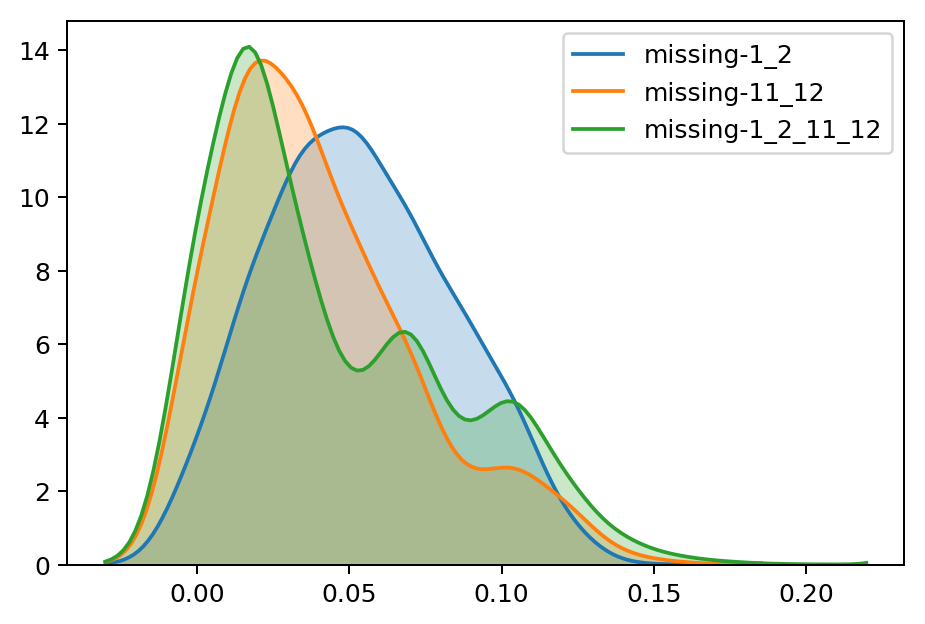

In [86]:
fig, ax = plt.subplots(dpi=180)
sns.kdeplot(intra_distances.distance[intra_distances['tree group'] == 'missing-1_2'].values,
            ax=ax, shade=True, label='missing-1_2', bw=0.01)
sns.kdeplot(intra_distances.distance[intra_distances['tree group'] == 'missing-11_12'].values,
            ax=ax, shade=True, label='missing-11_12', bw=0.01)
sns.kdeplot(intra_distances.distance[intra_distances['tree group'] == 'missing-1_2_11_12'].values,
            ax=ax, shade=True, label='missing-1_2_11_12', bw=0.01)

In [83]:
for group1, group2 in combinations(distances_to_whole_aln['tree group'].unique(), 2):
    i = distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == group1].values
    j = distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == group2].values
    if len(i) > len(j):
        i = i[:len(j)]
    else:
        j = j[:len(i)]
    print '%s VS %s: %f' % (group1, group2, ttest_ind(i, j).pvalue)

missing-11_12 VS missing-1_2: 0.272727
missing-11_12 VS missing-1_2_11_12: 0.697661
missing-1_2 VS missing-1_2_11_12: 0.553469


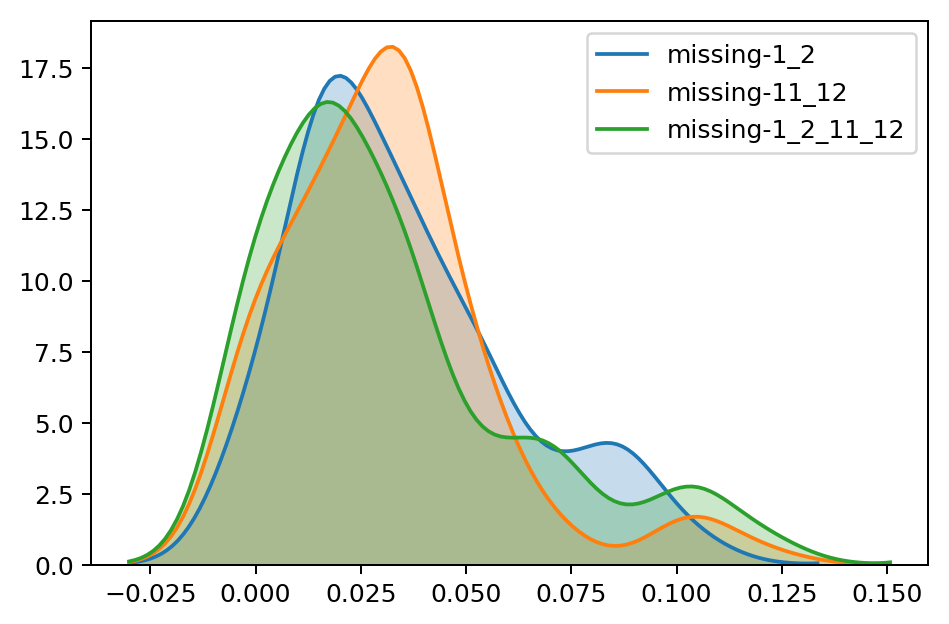

In [85]:
fig, ax = plt.subplots(dpi=180)
sns.kdeplot(distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == 'missing-1_2'].values,
            ax=ax, shade=True, label='missing-1_2', bw=0.01)
sns.kdeplot(distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == 'missing-11_12'].values,
            ax=ax, shade=True, label='missing-11_12', bw=0.01)
sns.kdeplot(distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == 'missing-1_2_11_12'].values,
            ax=ax, shade=True, label='missing-1_2_11_12', bw=0.01)